# M1 Coursework

Yuanzhen Zhao (yz929)

## Question 1

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import optuna

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

In [34]:
batch_size = 128
num_classes = 19
epochs = 20

(x_train, y_train), (x_test, y_test) = mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [35]:
images = np.concatenate((x_train, x_test), axis=0)
labels = np.concatenate((y_train, y_test), axis=0)

In [36]:
def create_combined_images(images, labels, dataset_size=10000, seed = 42):
    """Create a set of combined 56x28x1 images and labels."""
    np.random.seed(seed)
    combined_images = []
    combined_labels = []
    
    for _ in range(dataset_size):
        idx1, idx2 = np.random.choice(np.arange(len(images)), 2, replace=True)
        img1, img2 = images[idx1], images[idx2]
        label1, label2 = labels[idx1], labels[idx2]
        
        combined_image = np.hstack((img1, img2))
        combined_label = label1 + label2
        
        combined_images.append(combined_image)
        combined_labels.append(combined_label)
        
    combined_images = np.array(combined_images).reshape(-1, 28, 56, 1)
    combined_labels = np.array(combined_labels)
    
    return combined_images, combined_labels

In [37]:
def generate_dataset(images, labels, dataset_size, num_classes = 10, label_one_hot = False, seed = 42):
    """Generate a train, validation & test dataset of 28x28 images and labels."""
    np.random.seed(seed)
    train_size = int(0.6 * dataset_size)
    val_size = int(0.2 * dataset_size)
    # test_size = dataset_size - train_size - val_size
    
    image_samples = []
    label_samples = []
    
    for _ in range(dataset_size):
        idx = np.random.choice(np.arange(len(images)))
        img = images[idx]
        label = labels[idx]
        image_samples.append(img)
        label_samples.append(label)
        
    images = np.array(image_samples).reshape(-1, 28, 28, 1)
    labels = np.array(label_samples)
        
    train_images, train_labels = images[:train_size], labels[:train_size]
    val_images, val_labels = images[train_size:train_size+val_size], labels[train_size:train_size+val_size]
    test_images, test_labels = images[train_size+val_size:], labels[train_size+val_size:]
    
    if label_one_hot:
        train_labels = to_categorical(train_labels, num_classes)
        val_labels = to_categorical(val_labels, num_classes)
        test_labels = to_categorical(test_labels, num_classes)
        
    print("Train 28x28 images shape: ", train_images.shape)
    print("Validation 28x28 images shape: ", val_images.shape)
    print("Test 28x28 images shape: ", test_images.shape)
        
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)    

In [38]:
def generate_combined_dataset(images, labels, dataset_size, num_classes = 19, label_one_hot = False):
    """Generate a train, validation & test dataset of 56x28 images and labels."""
    train_size = int(0.6 * dataset_size)
    val_size = int(0.2 * dataset_size)
    # test_size = dataset_size - train_size - val_size
    
    combined_images, combined_labels = create_combined_images(images, labels, dataset_size)
    
    train_images, train_labels = combined_images[:train_size], combined_labels[:train_size]
    val_images, val_labels = combined_images[train_size:train_size+val_size], combined_labels[train_size:train_size+val_size]
    test_images, test_labels = combined_images[train_size+val_size:], combined_labels[train_size+val_size:]
    
    if label_one_hot:
        train_labels = to_categorical(train_labels, num_classes)
        val_labels = to_categorical(val_labels, num_classes)
        test_labels = to_categorical(test_labels, num_classes)
        
    print("Train 56x28 images shape: ", train_images.shape)
    print("Validation 56x28 images shape: ", val_images.shape)
    print("Test 56x28 shape: ", test_images.shape)
        
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

In [46]:
# Generate dataset of combined images
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = generate_combined_dataset(images, labels, dataset_size=100000, label_one_hot=True)

Train 56x28 images shape:  (60000, 28, 56, 1)
Validation 56x28 images shape:  (20000, 28, 56, 1)
Test 56x28 shape:  (20000, 28, 56, 1)


## Question 2

In [47]:
np.random.seed(42)

In [48]:
def objective(trial):
    # Suggest values for hyperparameters
    num_units_layer1 = trial.suggest_int("units_layer1", 128, 512, step=128)
    num_units_layer2 = trial.suggest_int("units_layer2", 128, 512, step=128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [128, 256, 512])

    # Build the model
    model = Sequential([
        Input(shape=(28, 56, 1)),
        Flatten(),
        Dense(num_units_layer1, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_units_layer2, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model
    history = model.fit(
        train_images, train_labels,
        validation_data=(val_images, val_labels),
        epochs=20,  # Use a small number of epochs for tuning
        batch_size=batch_size,
        verbose=0  # Suppress output for faster tuning
    )
    
    # Evaluate the model on validation data
    val_accuracy = history.history['val_accuracy'][-1]  # Last epoch's validation accuracy
    return -val_accuracy


In [49]:
# This cell takes around 30 mins to run
study = optuna.create_study(direction="minimize", load_if_exists=True)
study.optimize(objective, n_trials=30)

best_params = study.best_params
best_accuracy = -study.best_value 
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

[I 2024-12-14 15:55:32,170] A new study created in memory with name: no-name-804cb3e6-3fdf-455e-9f69-89a6cd542867
[I 2024-12-14 15:55:53,243] Trial 0 finished with value: -0.911300003528595 and parameters: {'units_layer1': 512, 'units_layer2': 128, 'dropout_rate': 0.1, 'learning_rate': 0.0051496837654178475, 'batch_size': 256}. Best is trial 0 with value: -0.911300003528595.
[I 2024-12-14 15:56:09,123] Trial 1 finished with value: -0.9135500192642212 and parameters: {'units_layer1': 128, 'units_layer2': 512, 'dropout_rate': 0.2, 'learning_rate': 0.001173912747210301, 'batch_size': 256}. Best is trial 1 with value: -0.9135500192642212.
[I 2024-12-14 15:56:27,176] Trial 2 finished with value: -0.7430999875068665 and parameters: {'units_layer1': 128, 'units_layer2': 384, 'dropout_rate': 0.4, 'learning_rate': 0.007030930799710272, 'batch_size': 256}. Best is trial 1 with value: -0.9135500192642212.
[I 2024-12-14 15:56:50,470] Trial 3 finished with value: -0.9077500104904175 and parameters:

Best parameters: {'units_layer1': 512, 'units_layer2': 384, 'dropout_rate': 0.4, 'learning_rate': 0.0013572484685955154, 'batch_size': 128}
Best validation accuracy: 0.9369


In [50]:
callback = EarlyStopping(monitor='val_accuracy', patience=3)

# Build the best model with the optimized parameters
best_model = Sequential([
    Input(shape=(28, 56, 1)),
    Flatten(),
    Dense(best_params['units_layer1'], activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(best_params['units_layer2'], activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [51]:
best_model.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the best model on the full training set
best_model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=50,
    batch_size=best_params['batch_size'],
    callbacks=[callback]
)

test_predictions = best_model.predict(test_images).argmax(axis=1)

test_accuracy = accuracy_score(test_labels.argmax(axis=1), test_predictions)

print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/50


469/469 [==============================] - 3s 6ms/step - loss: 1.5040 - accuracy: 0.5056 - val_loss: 0.7522 - val_accuracy: 0.7718
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 0.7378 - accuracy: 0.7705 - val_loss: 0.5192 - val_accuracy: 0.8453
Epoch 3/50
469/469 [==============================] - 3s 7ms/step - loss: 0.5462 - accuracy: 0.8321 - val_loss: 0.4383 - val_accuracy: 0.8707
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.4425 - accuracy: 0.8647 - val_loss: 0.3864 - val_accuracy: 0.8865
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.3822 - accuracy: 0.8829 - val_loss: 0.3576 - val_accuracy: 0.8962
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.3346 - accuracy: 0.8969 - val_loss: 0.3295 - val_accuracy: 0.9042
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 0.3036 - accuracy: 0.9050 - val_loss: 0.3108 - val_accuracy: 0.9125
Epoch 8/50
469/46

In [52]:
# Save the weights and architecture of the best model
best_model.save_weights('my_best_model.weights.h5')
plot_model(best_model, to_file='plots/model.png', show_shapes=True, show_layer_names=True)

## Question 3

In [61]:
# A smaller dataset for unsupervised learning

(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = generate_combined_dataset(images, labels, 60000, label_one_hot=False)

# Flatten the images
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

Train 56x28 images shape:  (36000, 28, 56, 1)
Validation 56x28 images shape:  (12000, 28, 56, 1)
Test 56x28 shape:  (12000, 28, 56, 1)


In [ ]:
# Random Forest Classifier
# This cell takes around 1.5 mins to run

RndFrstClass = RandomForestClassifier(n_estimators=500, max_depth=50)
RndFrstClass.fit(train_images_flat, train_labels)
RndFrstPred = RndFrstClass.predict(test_images_flat)

RFC_model_accuracy = accuracy_score(test_labels, RndFrstPred)
print(f"Accuracy of Random Forest Classifier: {RFC_model_accuracy}")

Accuracy of Random Forest Classifier: 0.7394166666666667


In [66]:
# Support Vector Classifier
# This cell takes around 25 mins to run

svcClass = SVC(kernel='rbf')
svcClass.fit(train_images_flat, train_labels) 
svcPred = svcClass.predict(test_images_flat)

SVC_model_accuracy = accuracy_score(test_labels, svcPred)
print(f"Accuracy of Support Vector Classifier: {SVC_model_accuracy}")

Accuracy of Support Vector Classifier: 0.7225


## Question 4

In [72]:
# Single layer perceptron as weak linear classifier

def one_image_model(X_train, y_train, X_test, y_test):
    model = Sequential([Input(shape=(28, 56, 1)), Flatten(), Dense(19, activation='softmax')])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=25, batch_size=64, verbose=0)
    
    prediction = model.predict(X_test)
    y_test_predicted = np.argmax(prediction, axis=1)
    y_test = np.argmax(y_test, axis=1)
    test_accuracy = accuracy_score(y_test, y_test_predicted)
    
    return test_accuracy

def two_images_model(X_train, y_train, X_test_first, y_test_first, X_test_second, y_test_second):    
    model = Sequential([Input(shape=(28, 28, 1)), Flatten(), Dense(10, activation='softmax')])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=25, batch_size=64, verbose=0)
    prediction1 = model.predict(X_test_first)
    y_test_first_predicted = np.argmax(prediction1, axis=1)
    y_test_first = np.argmax(y_test_first, axis=1)
    prediction2 = model.predict(X_test_second)
    y_test_second_predicted = np.argmax(prediction2, axis=1)
    y_test_second = np.argmax(y_test_second, axis=1)
    
    test_accuracy = accuracy_score(y_test_first + y_test_second, y_test_first_predicted + y_test_second_predicted)
    
    return test_accuracy

In [73]:
print("ONE IMAGE")
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = generate_combined_dataset(images, labels, 20000, label_one_hot=True)
print("\nTWO IMAGES")
(train_separate_images, train_separate_labels), (val_separate_images, val_separate_labels), (test_separate_images, test_separate_labels) = generate_dataset(images, labels, 12000, label_one_hot=True)

ONE IMAGE
Train 56x28 images shape:  (12000, 28, 56, 1)
Validation 56x28 images shape:  (4000, 28, 56, 1)
Test 56x28 shape:  (4000, 28, 56, 1)

TWO IMAGES
Train 28x28 images shape:  (7200, 28, 28, 1)
Validation 28x28 images shape:  (2400, 28, 28, 1)
Test 28x28 images shape:  (2400, 28, 28, 1)


In [74]:
sample_sizes = [50, 100, 500, 1000]
results_single = []
results_two = []

In [75]:
for size in sample_sizes:
    # Sample a subset for training
    train_images_subset, train_labels_subset = train_images[:size], train_labels[:size]
    
    # Method 1: Classify on a single 56x28 image
    acc_single = one_image_model(train_images_subset, train_labels_subset, test_images, test_labels)
    results_single.append((size, acc_single))
    
    test_images_first, test_labels_first = test_separate_images[:size], test_separate_labels[:size]
    test_images_second, test_labels_second = test_separate_images[size:2*size], test_separate_labels[size:2*size]
        
    # Method 2: Classify on two separate 28x28 images
    acc_two = two_images_model(train_separate_images, train_separate_labels, test_images_first, test_labels_first, test_images_second, test_labels_second)
    results_two.append((size, acc_two))

32/32 [==============================] - 0s 593us/step


In [79]:
# Visualise results
results_single = np.array(results_single)
results_two = np.array(results_two)

plt.figure()

plt.plot(results_single[:, 0], results_single[:, 1], label="One Image Model Accuracy", marker='o')
plt.plot(results_two[:, 0], results_two[:, 1], label="Two Images Model Accuracy", marker='o')
plt.xlabel("Number of Training Samples")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("plots/accuracy_comparison.png")
plt.show()

## Question 5

t-SNE distribution of embedding layer

In [53]:
# Re-generate the same combined dataset as optuna optimised with (label not one-hot encoded)
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = generate_combined_dataset(images, labels, dataset_size=100000, label_one_hot=False)

Train 56x28 images shape:  (60000, 28, 56, 1)
Validation 56x28 images shape:  (20000, 28, 56, 1)
Test 56x28 shape:  (20000, 28, 56, 1)


625/625 [==============================] - 2s 2ms/step


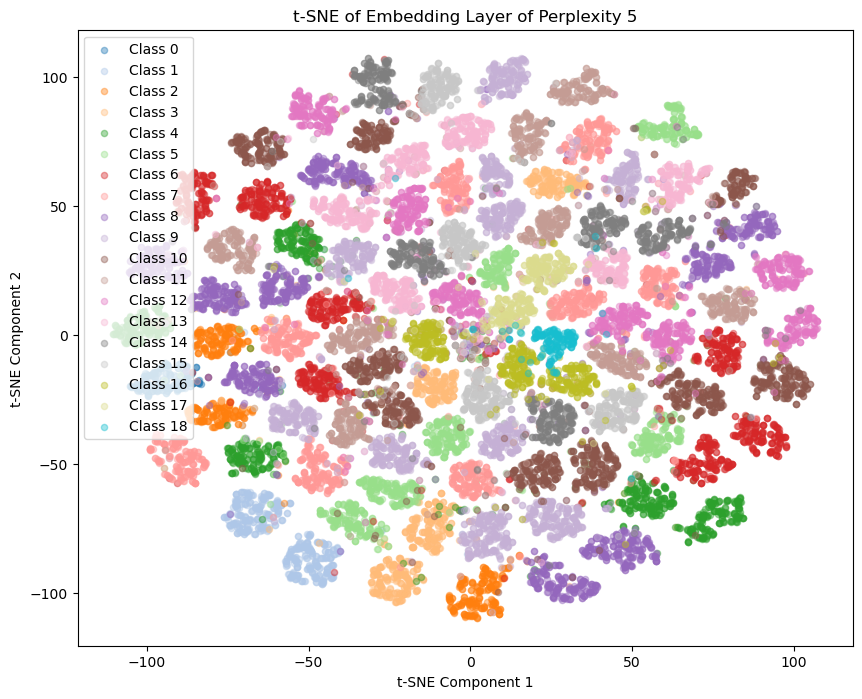

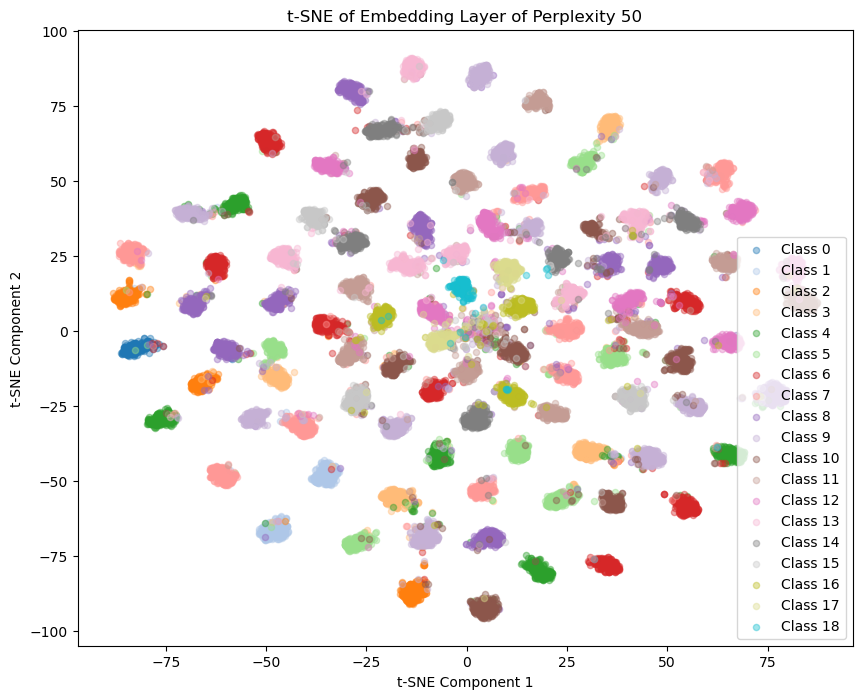

In [ ]:
# This cell takes around 8 mins to run
embedding_model = Model(inputs=best_model.layers[0].input, outputs=best_model.layers[-2].output)
embedding_output = embedding_model.predict(test_images)

perplexity_values = [5, 20, 50, 100]

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for ax, perplexity in zip(axes, perplexity_values):

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    reduced_embeddings = tsne.fit_transform(embedding_output)

    # Manually set the colors for each class as default `tab10` only has 10 colors
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in range(num_classes)]

    for i in range(num_classes):
        idx = np.where(test_labels == i)
        length = len(reduced_embeddings[idx, 0])
        ax.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"Class {i}", alpha=0.4, color=colors[i], s=20)

    ax.set_title(f"Perplexity {perplexity}")
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    ax.legend()

plt.tight_layout()
plt.savefig("plots/tsne_embedding.png")
plt.show()

t-SNE distribution on the input dataset

In [55]:
# This cell takes around 8 mins to run
test_images_flat = test_images.reshape(test_images.shape[0], -1)
fig, axes = plt.subplots(1, 4, figsize=(12, 3))  # Create subplots in a horizontal layout

for ax, perplexity in zip(axes, perplexity_values):
    
    tsne_input = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    test_images_embedded = tsne_input.fit_transform(test_images_flat)
    
    for i in range(num_classes):
        idx = np.where(test_labels == i)
        ax.scatter(test_images_embedded[idx, 0], test_images_embedded[idx, 1], label=f"Class {i}", alpha=0.4, color=colors[i], s=20)

    ax.set_title(f"Perplexity {perplexity}")
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    ax.legend()

plt.tight_layout()
plt.savefig("plots/tsne_input.png")
plt.show()